In [1]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
import multiprocessing as mp
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from filters import modular_multi_matched_filter as mmf
from simulate import cluster_templates as cltemp

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# The catalogues were downloaded from analysis from on sirius5
# Downloaded from path : /scratch/nas_chluba/specdist/arotti/mmf_dataout/results/planck_pr3/planck_cat_hfi_inpainted_data/old_non_iterative_mmf/15deg_patches

In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


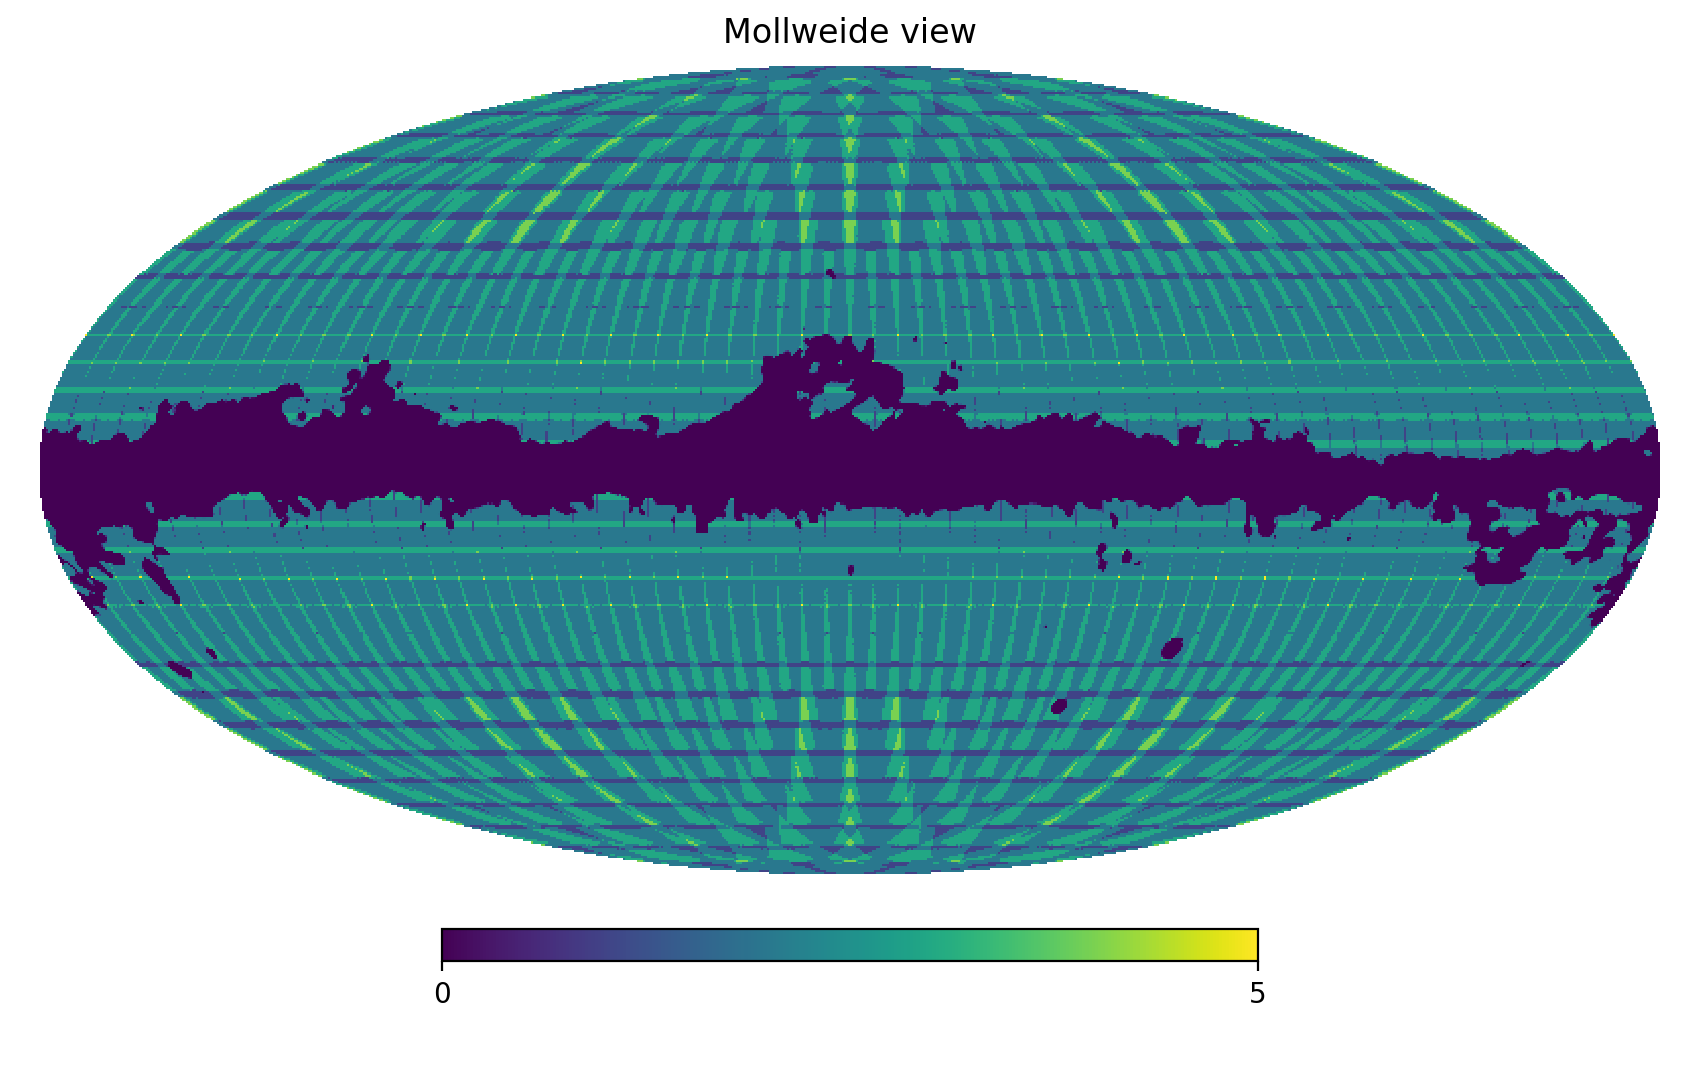

In [3]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)
filename=figpath + "tile_the_sky.pdf"
plt.savefig(filename,bbox_inches="tight",dpi=200)

In [4]:
for px in tiledef.keys():
    catname=gset.mmfset.result_path + "/data_old/" + tiledef[px]["TILENAME"] + ".dict"
    tiledef[px]['CATNAME']=catname

In [100]:
def myprint(text,verbose):
    if verbose:
        print text
        
def return_distance(gal_coord1,gal_coord2):
    glon1,glat1=gal_coord1
    glon2,glat2=gal_coord2
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    cosbeta=np.sign(cosbeta)*min(np.abs(cosbeta),1.)
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

vec_return_distance=np.vectorize(return_distance)
        
def return_final_cluster_catalogue(tiledef,verbose=False):
    tile_cluscat={}
#     for px in tiledef.keys():
#         if os.path.isfile(tiledef[px]["CATNAME"]):
#             temp_cat=etcc.read_dict(tiledef[px]["CATNAME"])
#             tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]
            
    all_files=os.listdir(gset.mmfset.result_path + "/data_old/")
    for tname in all_files:
        fname=gset.mmfset.result_path + "/data_old/" + tname
        temp_cat=etcc.read_dict(fname)
        px=temp_cat["pix"]
        tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]

    final_cat={}
    for tile in tile_cluscat.keys():
        for ict in tile_cluscat[tile].keys():
            nc=[]
            for jct in final_cat.keys():
                dist=return_distance(tile_cluscat[tile][ict]["mp_gal_coord"],final_cat[jct]["mp_gal_coord"])
                nc=nc + [dist<tile_cluscat[tile][ict]["mp_thetac"] or dist<final_cat[jct]["mp_thetac"]]

            if any(nc):
                myprint("This cluster exists in the catalogue",verbose)
                match_ict=np.where(nc)[0][0]
                if tile_cluscat[tile][ict]["mp_snr"]>final_cat[match_ict]["mp_snr"]:
                    myprint("Updating the cluster definition",verbose)
                    final_cat[match_ict]=tile_cluscat[tile][ict]
            else:
                myprint("New cluster detected, adding to the cluster catalogue",verbose)
                match_ict=len(final_cat.keys())
                final_cat[match_ict]=tile_cluscat[tile][ict]
    cat_summary={}
    cat_summary["Total clusters"]=len(final_cat.keys())
    cat_summary["Catalogue"]=final_cat
    catname=gset.mmfset.paths["result_data"] + "full_sky_catalogue.dict"
#     write_dict(catname,cat_summary)
    return cat_summary

In [104]:
cat_summary=return_final_cluster_catalogue(tiledef)

In [206]:
cat_iter=etcc.read_dict("../../results/planck_pr3/planck_cat_hfi_inpainted_data/15deg_patches/data_iter/full_sky_catalogue.dict")

<IPython.core.display.Javascript object>


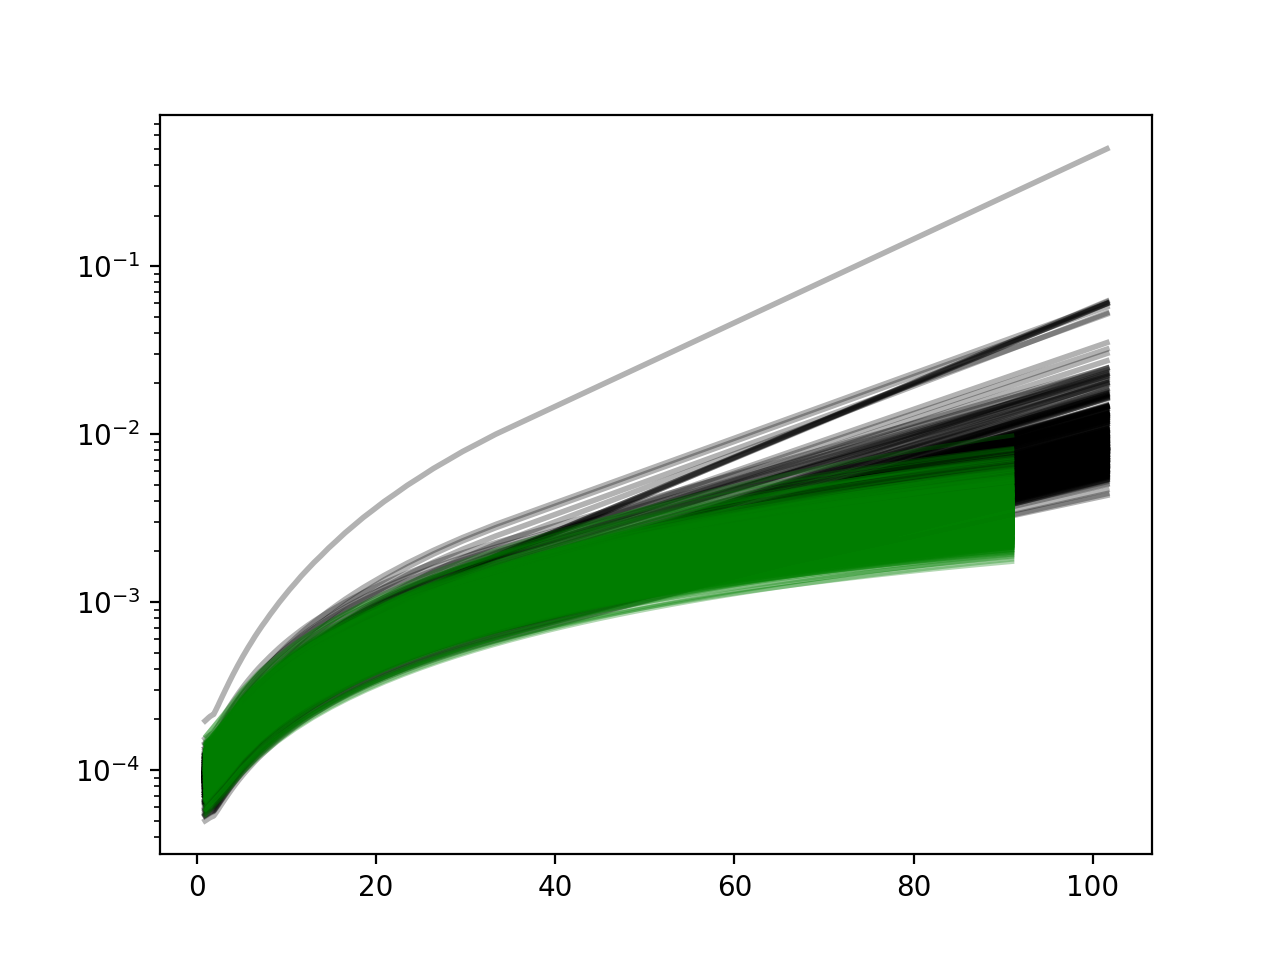

<IPython.core.display.Javascript object>


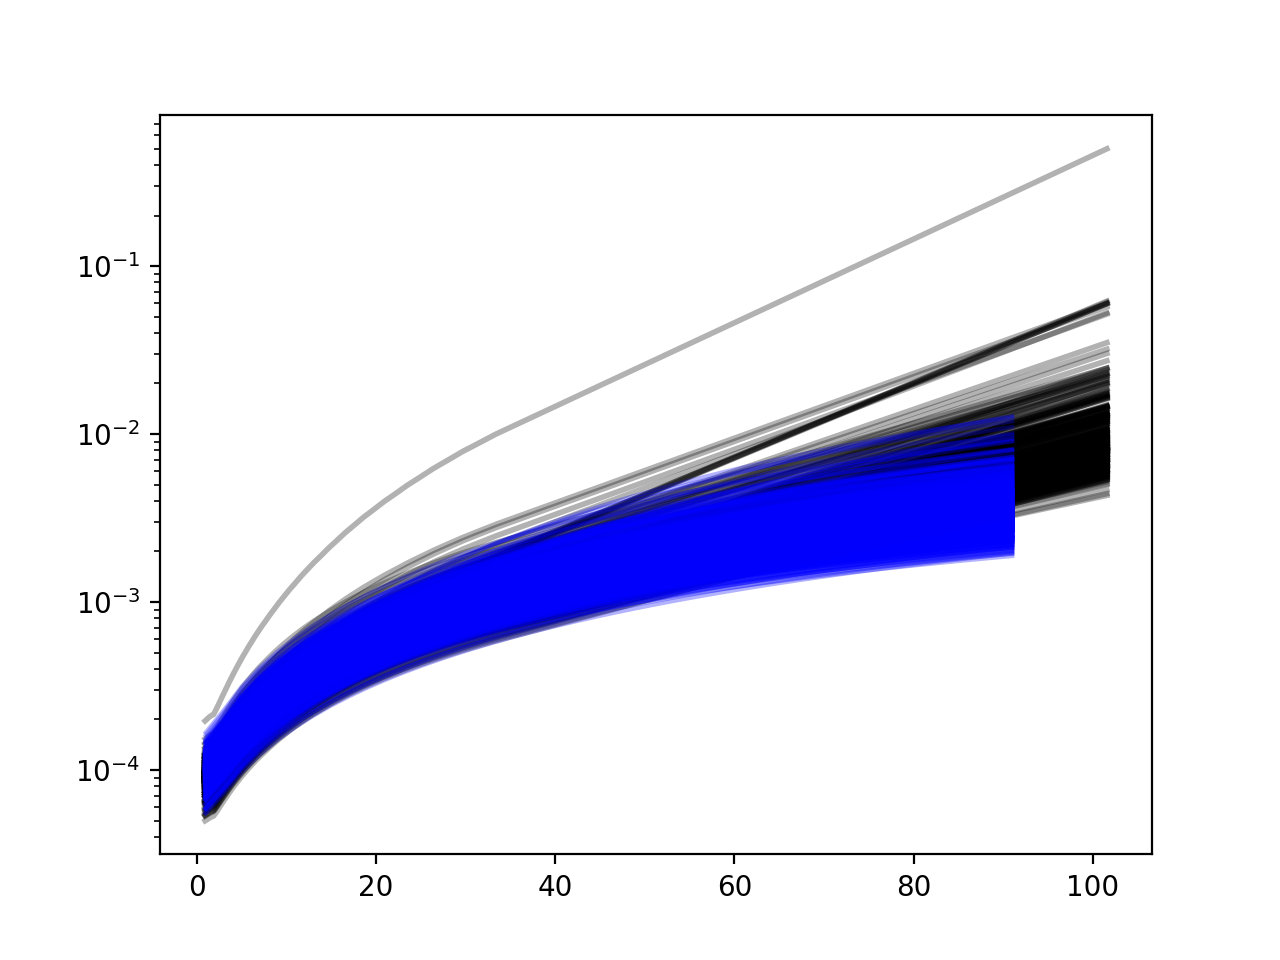

<IPython.core.display.Javascript object>


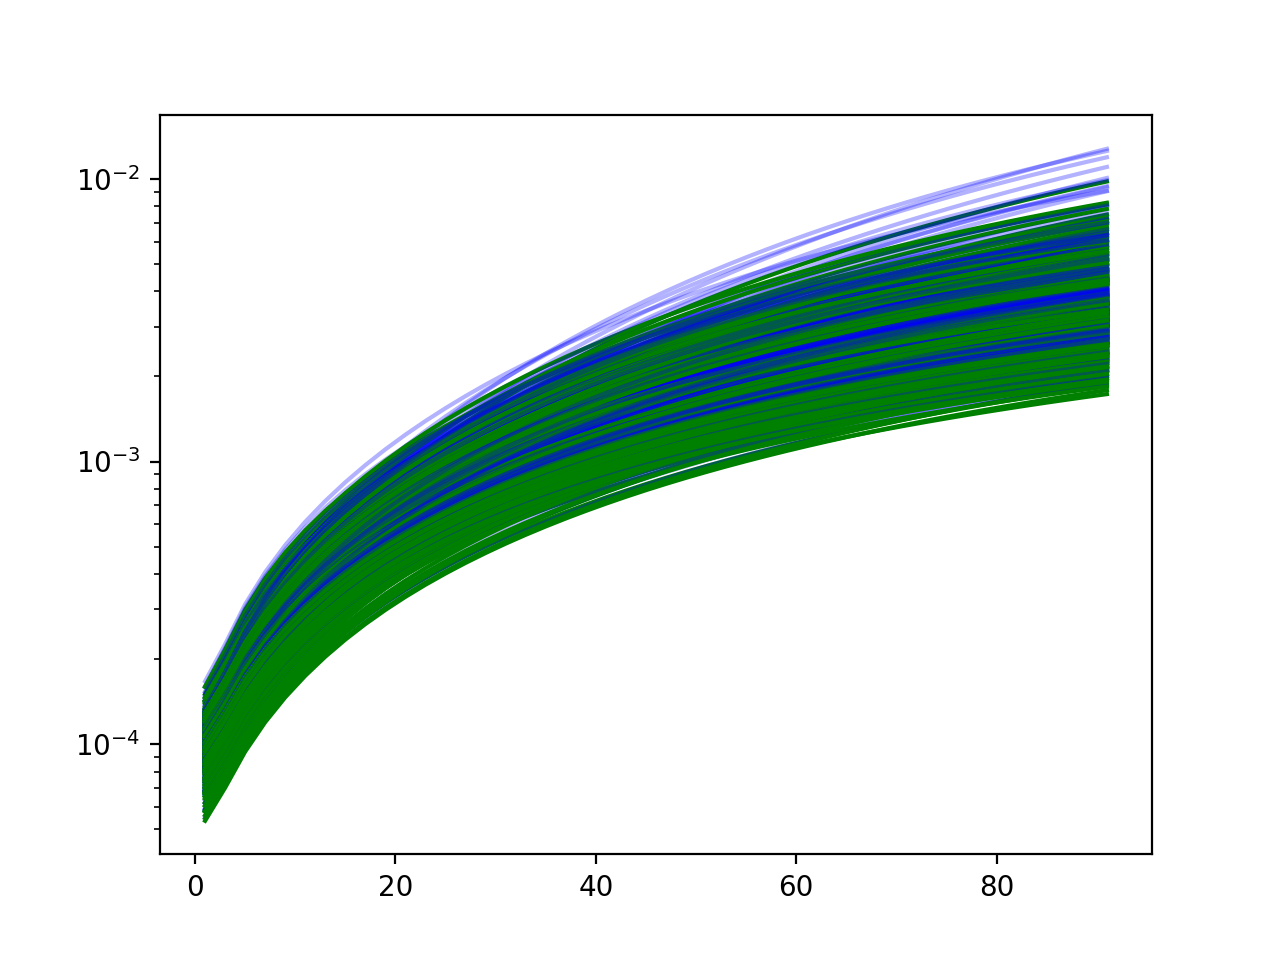

[]

In [346]:
skyfracs=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_skyfracs.txt")
ylims=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_ylims.txt")
thetas=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_thetas.txt")

sig=np.zeros((np.size(skyfracs),np.size(thetas)),float)
cnt_patch=1
cnt_thetas=1
for i in range(np.size(ylims)):
    sig[cnt_patch-1,cnt_thetas-1]=ylims[i]
    cnt_patch=cnt_patch+1
    if cnt_patch>np.size(skyfracs):
        cnt_patch=1
        cnt_thetas=cnt_thetas+1
        
figure()
# for i in range(np.size(skyfracs)):
for i in range(np.size(skyfracs)):
    if i==0:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3,label="Planck MMF3 (is it MMF3?)")
    else:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3)
for px in cat_iter["Tile MMF info"].keys():
#     plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500"],"b")
    plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500_rev"],"g-",alpha=0.3)
semilogy()

figure()
# for i in range(np.size(skyfracs)):
for i in range(np.size(skyfracs)):
    if i==0:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3,label="Planck MMF3 (is it MMF3?)")
    else:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3)
for px in cat_iter["Tile MMF info"].keys():
    plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500"],"b",alpha=0.3)
#     plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500_rev"],"g-")
semilogy()

figure()
for px in cat_iter["Tile MMF info"].keys():
    plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500"],"b",alpha=0.3)
    plot(cat_iter["Tile MMF info"][px]["theta500"],cat_iter["Tile MMF info"][px]["err_Y500_rev"],"g-")
semilogy()

In [214]:
err_Y500=np.zeros((h.nside2npix(8),len(cat_iter["Tile MMF info"][0]["theta500"])))
err_Y500_rev=np.zeros((h.nside2npix(8),len(cat_iter["Tile MMF info"][0]["theta500"])))
for px in cat_iter["Tile MMF info"].keys():
    err_Y500[px,:]=cat_iter["Tile MMF info"][px]["err_Y500"]
    err_Y500_rev[px,:]=cat_iter["Tile MMF info"][px]["err_Y500_rev"]

In [274]:
h.pix2ang(8,238,lonlat=True)

(337.49999999999994, 24.62431835216408)

<IPython.core.display.Javascript object>


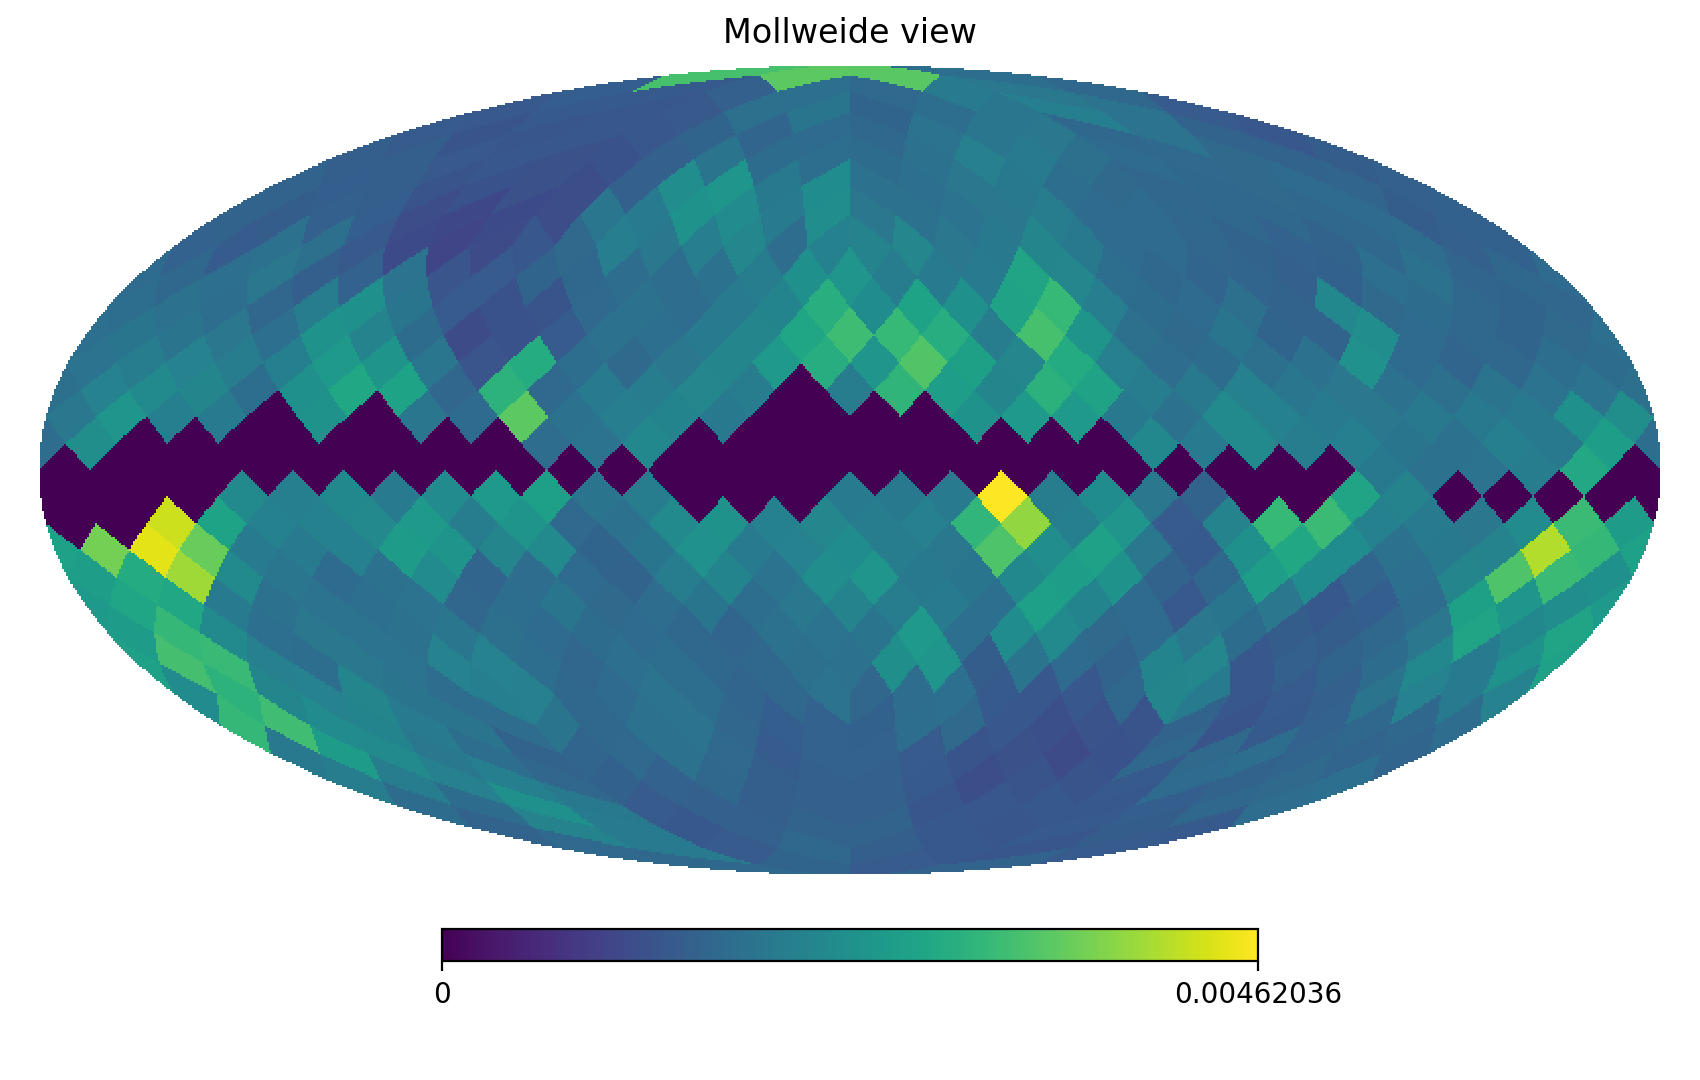

<IPython.core.display.Javascript object>


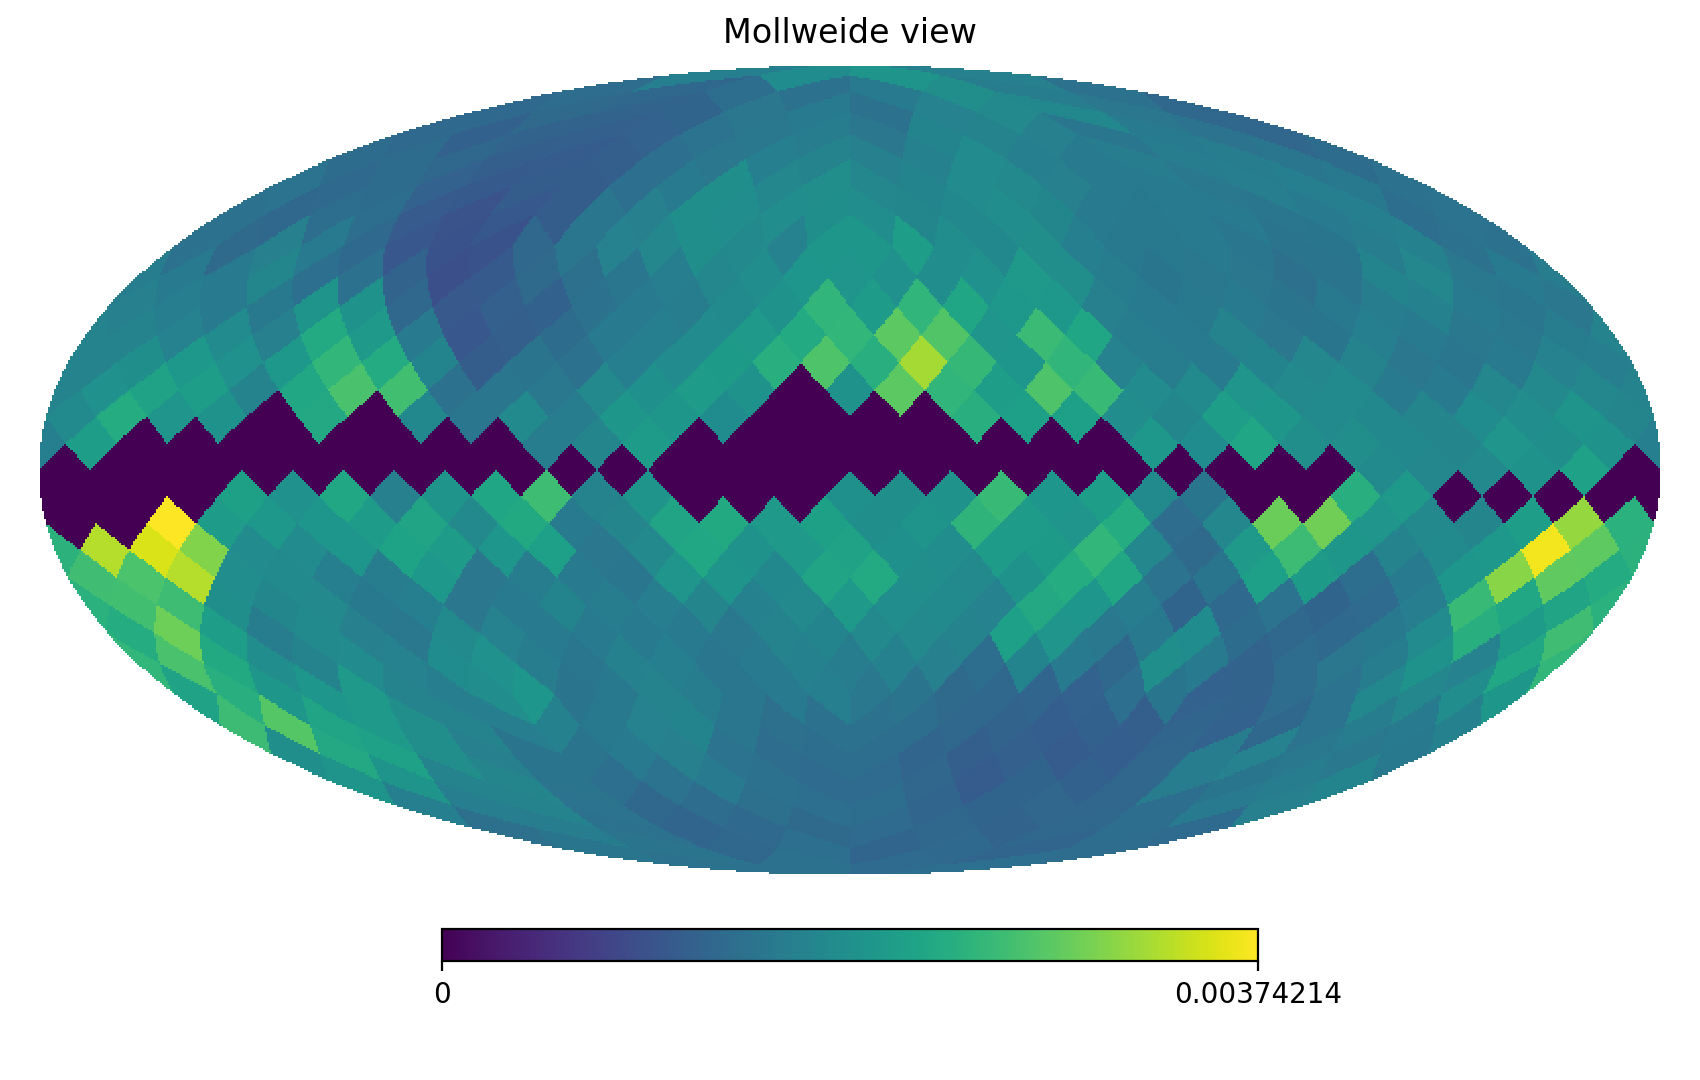

In [337]:
h.mollview(err_Y500[:,20])
h.mollview(err_Y500_rev[:,20])

In [59]:
from automated_detection import extract_tile_cluster_catalogue_v1 as etcc

In [30]:
for px in tiledef.keys():
    catname=gset.mmfset.result_path + "/data_old/" + tiledef[px]["TILENAME"] + ".dict"
    tiledef[px]['CATNAME']=catname

In [41]:
all_files=os.listdir(gset.mmfset.result_path + "/data_old/")

In [105]:
tile_cluscat={}
mmf_err=np.zeros((h.nside2npix(8),len(temp_cat["theta500"])))
tile_fsky=np.zeros(h.nside2npix(8))
missing_px=[]

all_files=os.listdir(gset.mmfset.result_path + "/data_old/")
for tname in all_files:
    fname=gset.mmfset.result_path + "/data_old/" + tname
    temp_cat=etcc.read_dict(fname)
    px=temp_cat["pix"]
    tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]
    tile_fsky[px]=temp_cat["fsky"]
    for ith,th in enumerate(temp_cat["theta500"]):
        mmf_err[px,ith]=temp_cat["err_Y500"][ith]

<IPython.core.display.Javascript object>


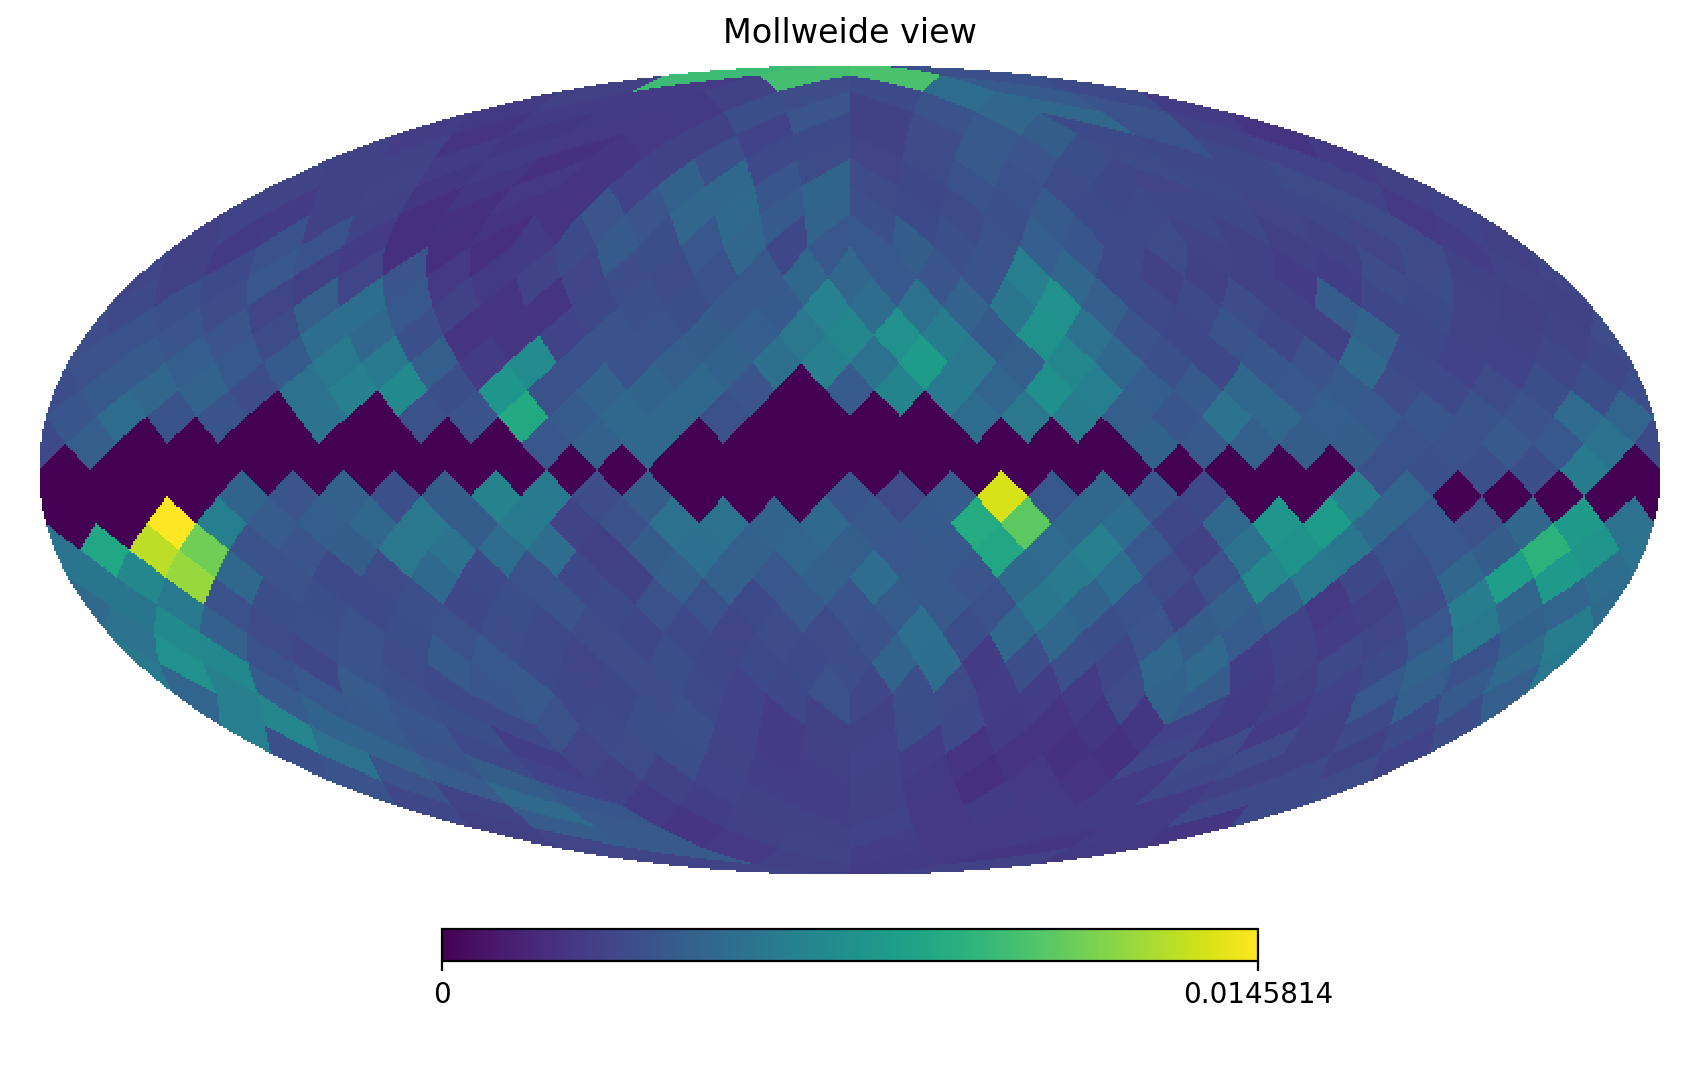

In [331]:
h.mollview(mmf_err[:,0],rot=(0,0))

In [333]:
def return_snr_list(cat):
    snr=np.array([])
    for idx in cat.keys():
        snr=np.append(snr,cat[idx]["mp_snr"])
    return snr

def return_ncmap(cat,nside=16,snrthr=4):
    ncmap=np.zeros(h.nside2npix(nside))
    for idx in cat.keys():
        px=h.ang2pix(nside,*cat[idx]["mp_gal_coord"],lonlat=True)
        if cat[idx]["mp_snr"]>=snrthr and mask[px]==1.:
            ncmap[px]=ncmap[px]+1
    return ncmap
        
        
    

snr=np.array([])
snr_rev=np.array([])
# thc=np.array([])
# thc_rev=np.array([])
# nsc=np.array([])
# nside=128
# ncmap=np.zeros(h.nside2npix(nside))
# thr_cat={}
# cnt=0
for idx in cat_iter["Catalogue"].keys():
    mysnr=cat_iter["Catalogue"][idx]["mp_snr"]
#     mysnr_rev=cat_iter["Catalogue rev"][idx]["mp_snr"]
#     theta500=cat_summary["Catalogue"][idx]["mp_thetac"]
#     num_scl=len(cat_summary["Catalogue"][idx]["snr"])
#     if mysnr>5 and num_scl>5.:
    px=h.ang2pix(nside,*cat_iter["Catalogue"][idx]["mp_gal_coord"],lonlat=True)
#         ncmap[px]=ncmap[px]+1
#         thr_cat[cnt]=cat_summary["Catalogue"][idx]
#         cnt=cnt+1
    snr=np.append(snr,mysnr)
#         snr_rev=np.append(snr,mysnr_rev)
#         thc=np.append(thc,theta500)
#         nsc=np.append(nsc,num_scl)

snr_rev=np.array([])
for idx in cat_iter["Catalogue rev"].keys():
    mysnr=cat_iter["Catalogue rev"][idx]["mp_snr"]
    snr_rev=np.append(snr_rev,mysnr)

In [334]:
snr_rev=return_snr_list(cat_iter["Catalogue rev"])
snr=return_snr_list(cat_iter["Catalogue"])

ncmap_rev=return_ncmap(cat_iter["Catalogue rev"],snrthr=4.)
ncmap=return_ncmap(cat_iter["Catalogue"],snrthr=4.)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


<IPython.core.display.Javascript object>


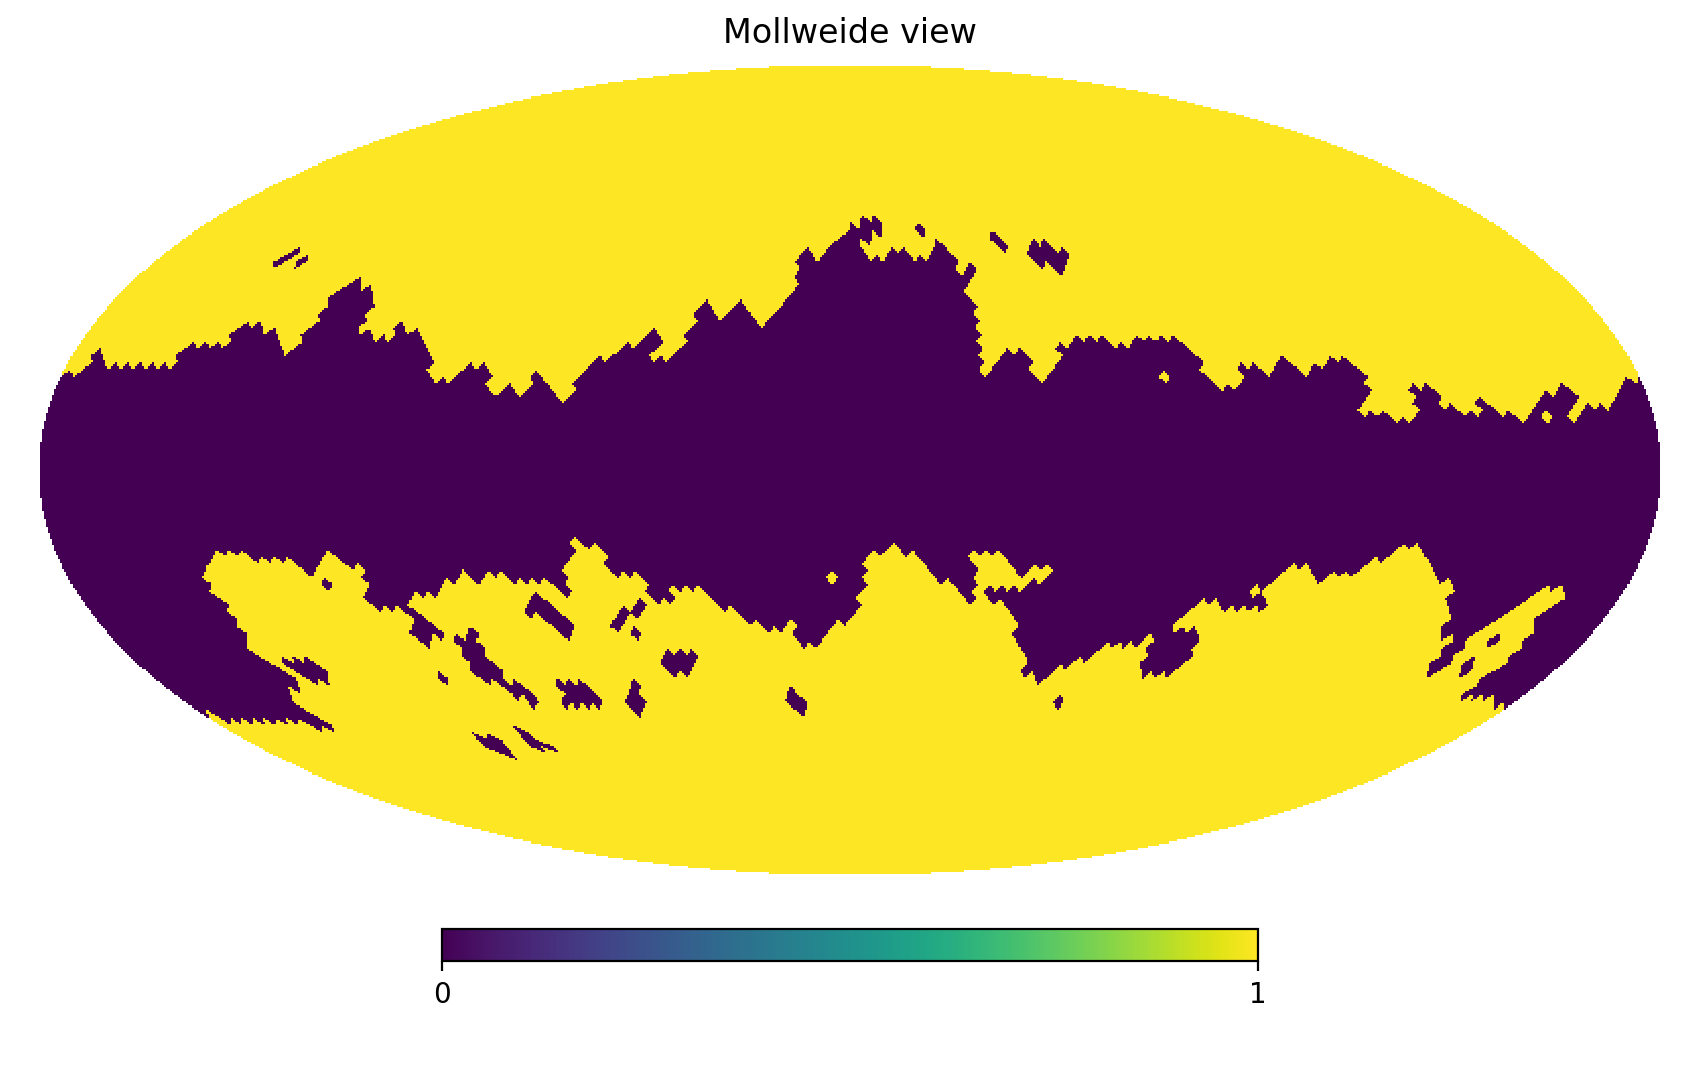

In [335]:
nside=32
mask=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits")
mask=h.ud_grade(mask,nside)
mask[mask<0.7]=0
mask[mask>=0.7]=1

h.mollview(mask)

<IPython.core.display.Javascript object>


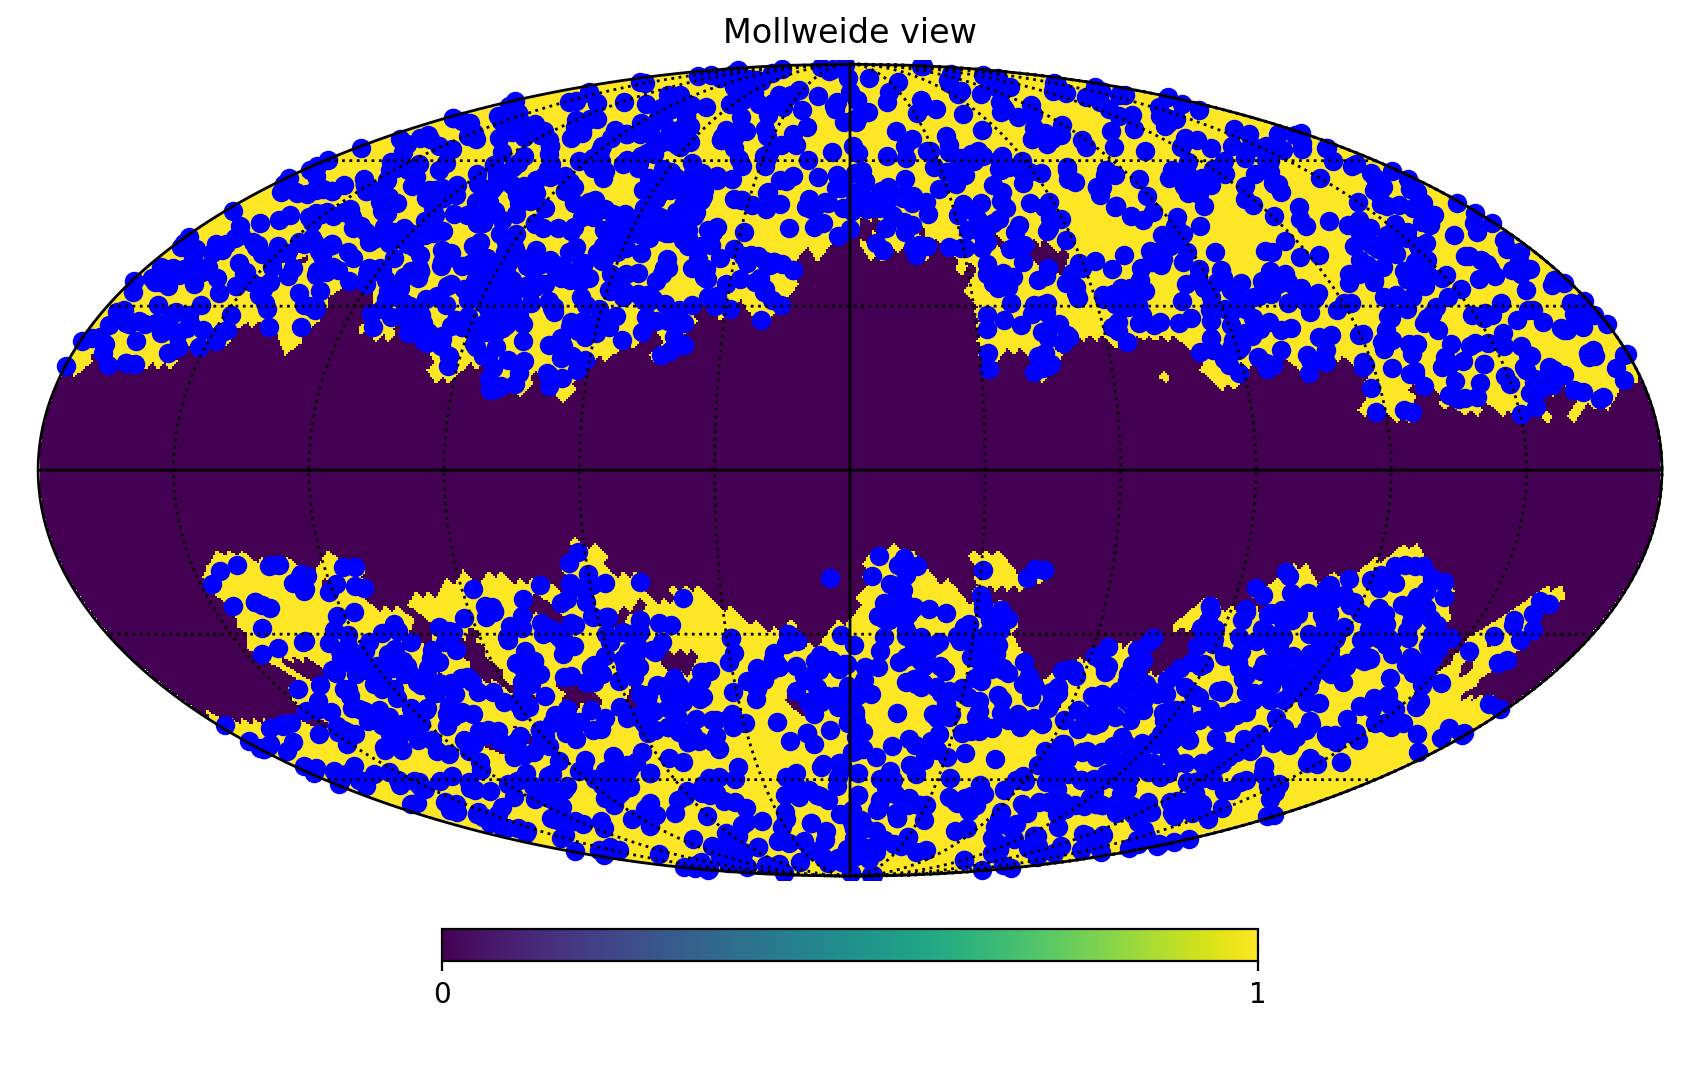

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


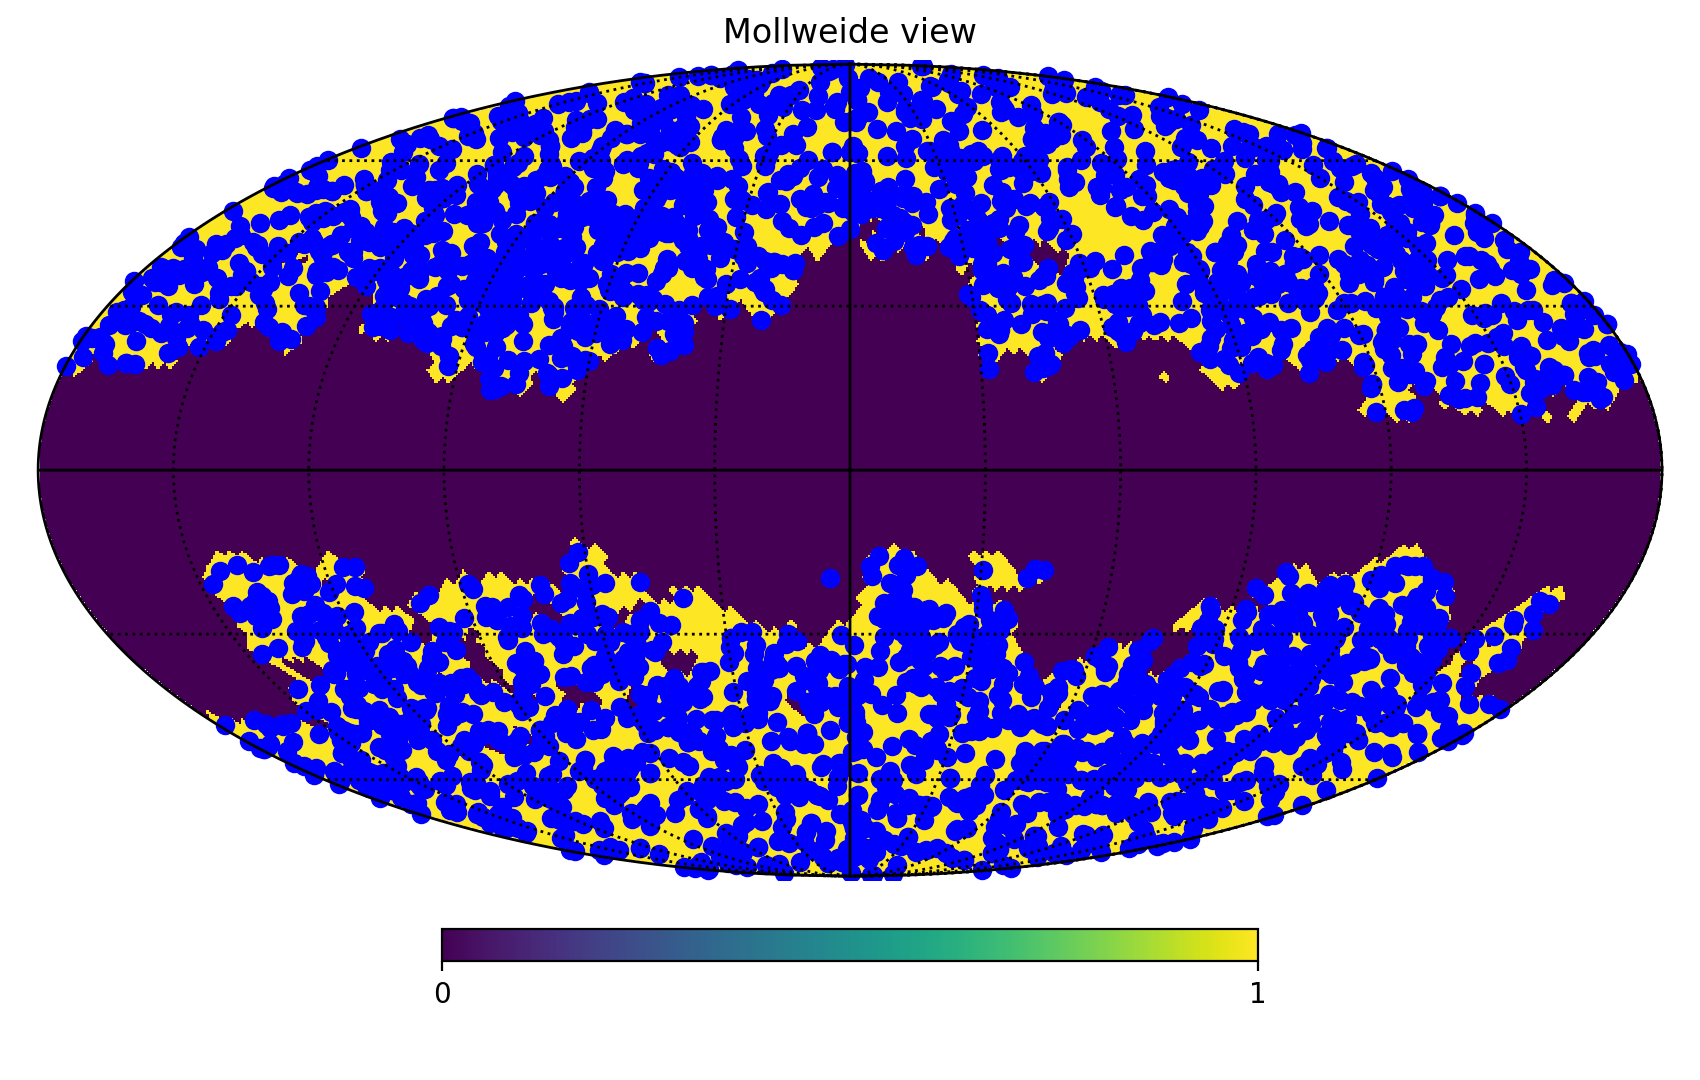

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [332]:
ion()
h.mollview(mask)
h.graticule()
for idx in cat_iter["Catalogue rev"].keys():
    px=h.ang2pix(nside,*cat_iter["Catalogue rev"][idx]["mp_gal_coord"],lonlat=True)
    if cat_iter["Catalogue rev"][idx]["mp_snr"]>=4 and mask[px]==1:
        h.projscatter(cat_iter["Catalogue rev"][idx]["mp_gal_coord"],lonlat=True,color="b")
        
h.mollview(mask)
h.graticule()
for idx in cat_iter["Catalogue"].keys():
    px=h.ang2pix(nside,*cat_iter["Catalogue"][idx]["mp_gal_coord"],lonlat=True)
    if cat_iter["Catalogue"][idx]["mp_snr"]>=4 and mask[px]==1:
        h.projscatter(cat_iter["Catalogue"][idx]["mp_gal_coord"],lonlat=True,color="b")

In [298]:
sum(ncmap),sum(ncmap_rev)

(1449.0, 1444.0)

<IPython.core.display.Javascript object>


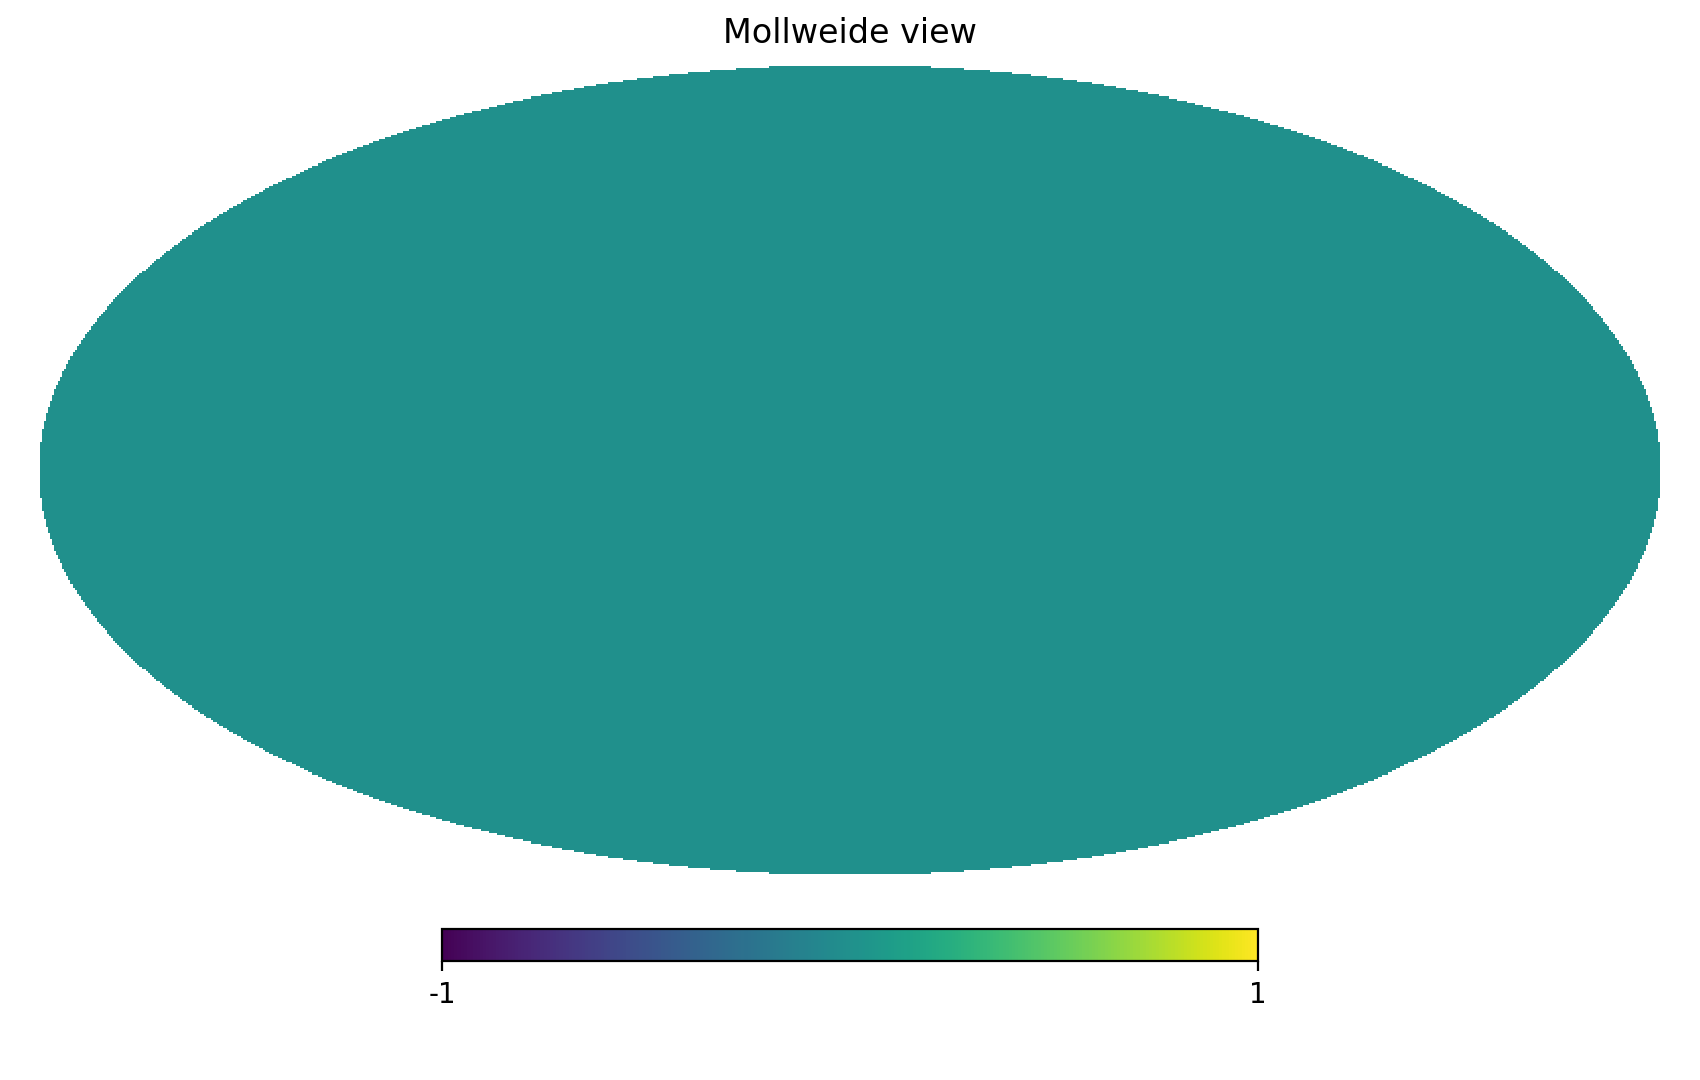

<IPython.core.display.Javascript object>


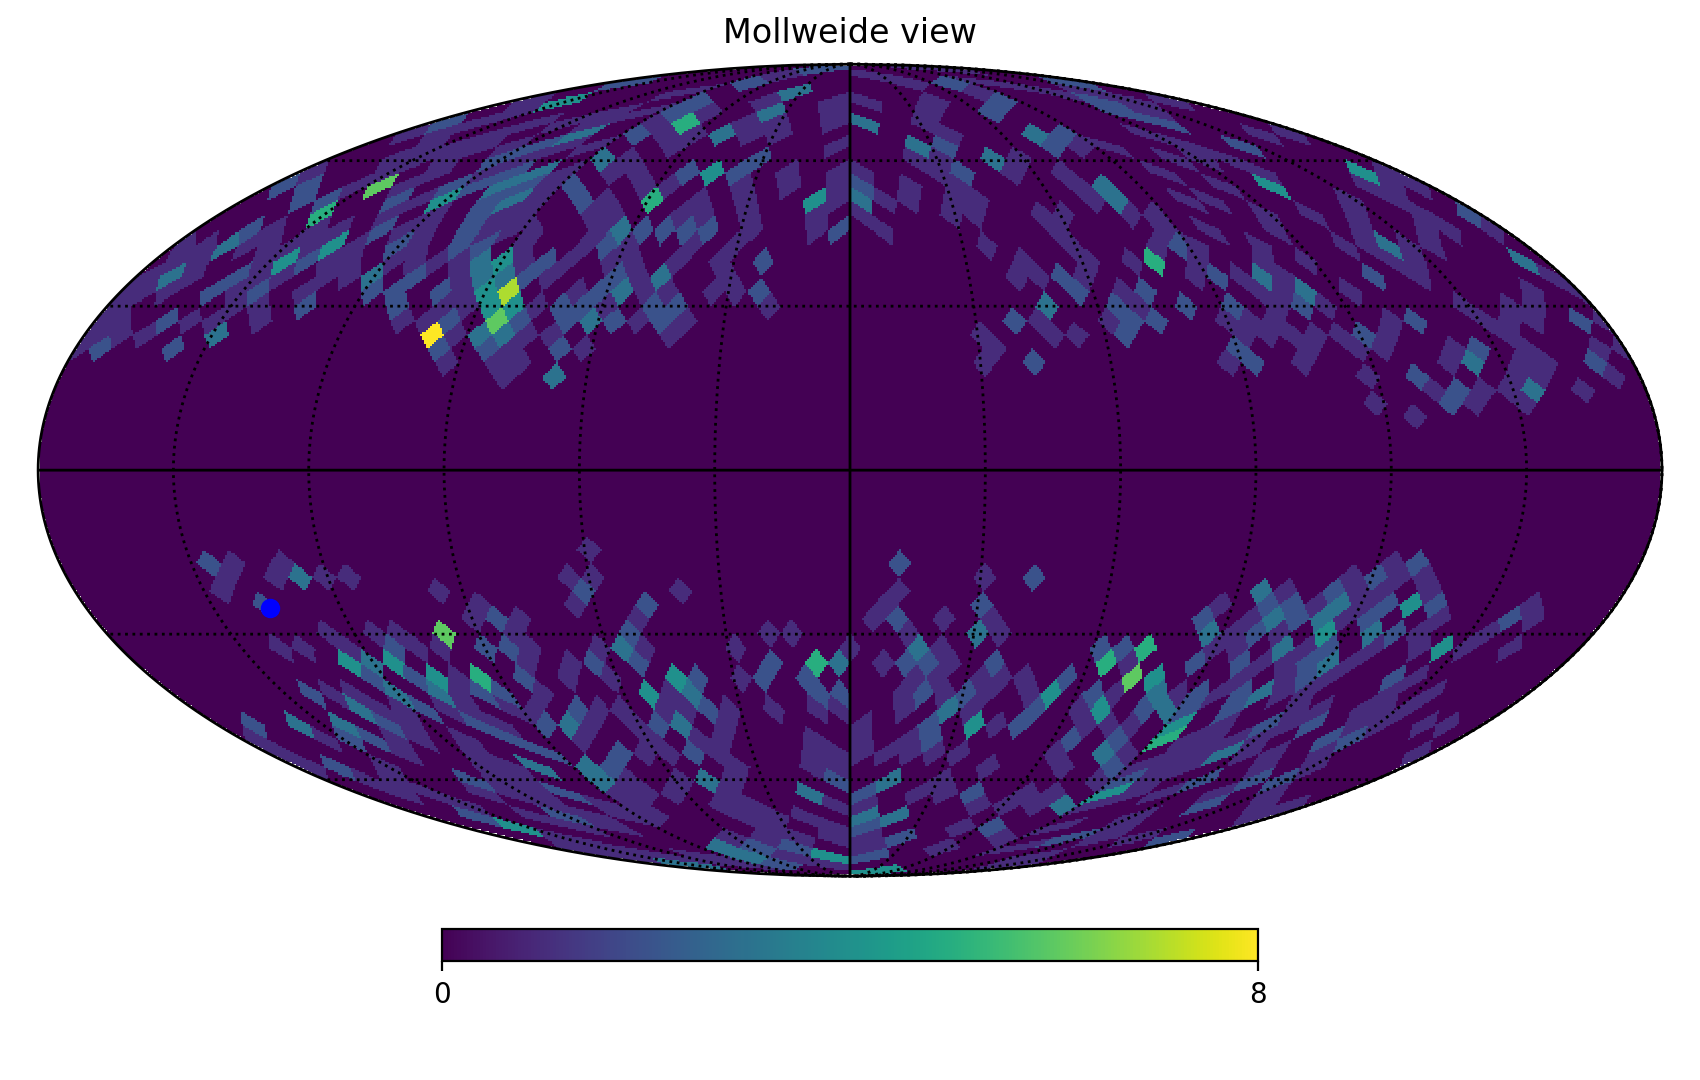

In [307]:
h.mollview(ncmap_rev)

In [267]:
np.where(ncmap==max(ncmap))

(array([238]),)

In [270]:
ncmap[:]=0
ncmap[238]=20

<IPython.core.display.Javascript object>


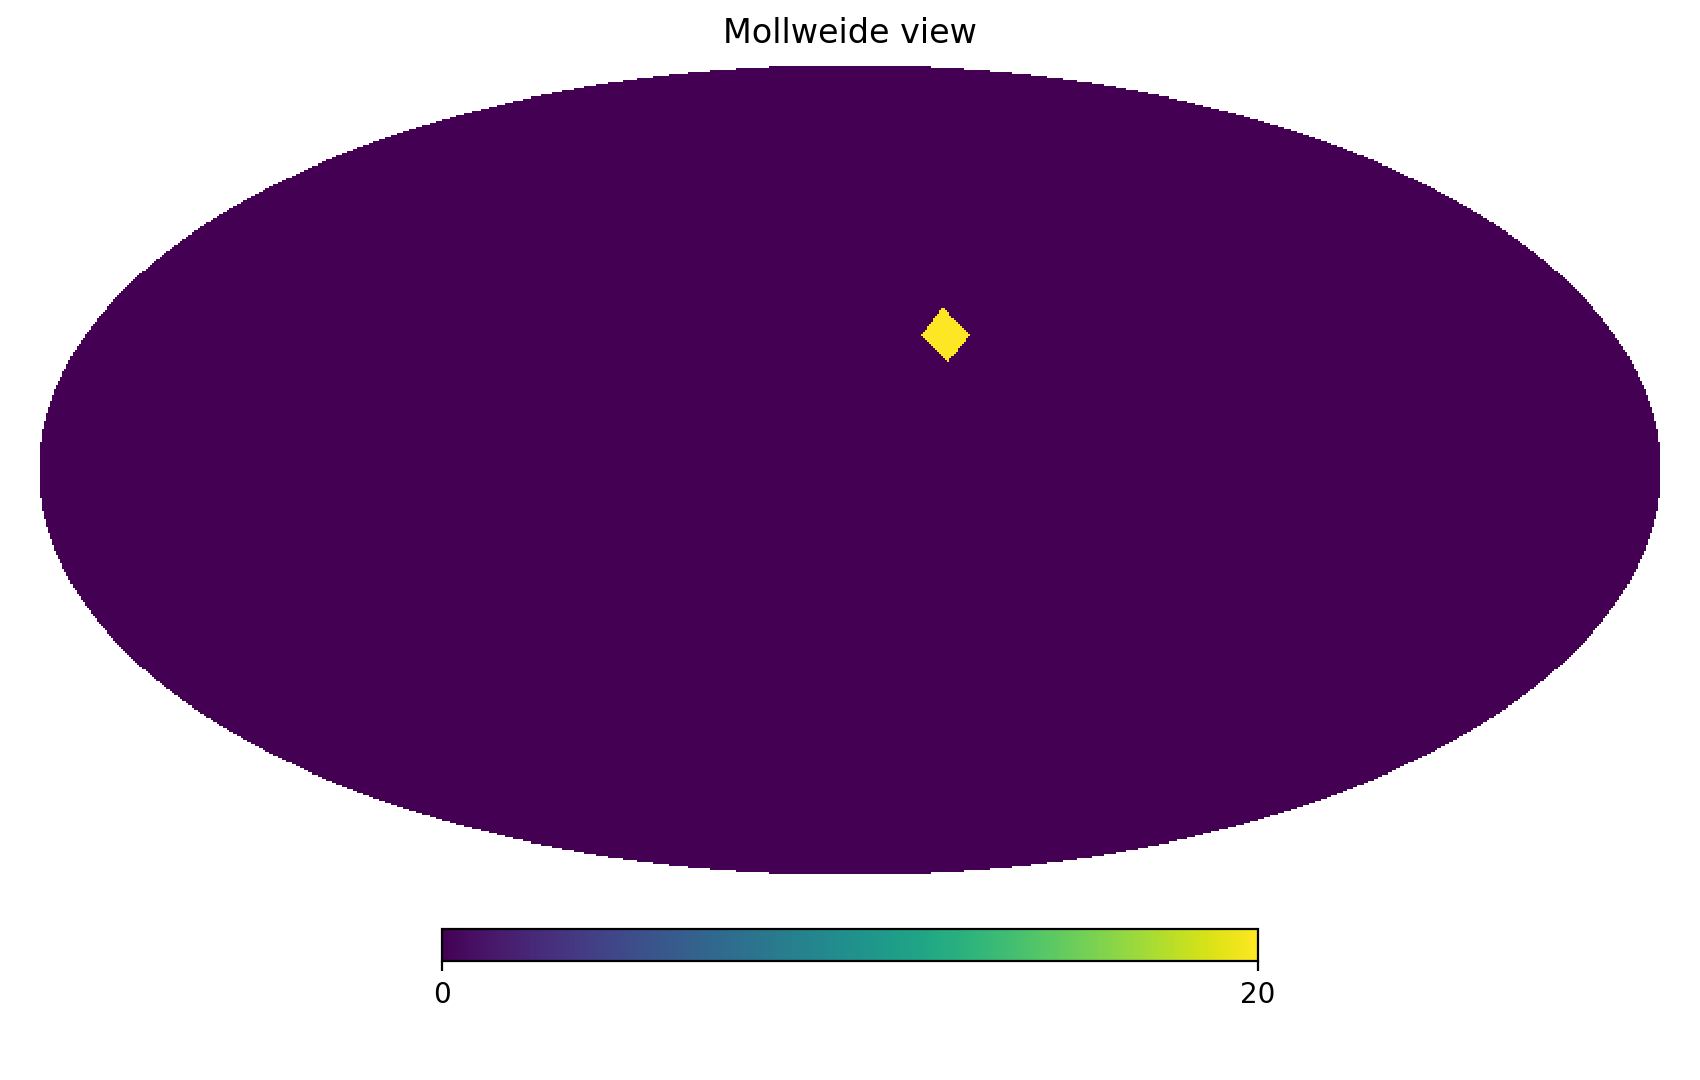

<IPython.core.display.Javascript object>


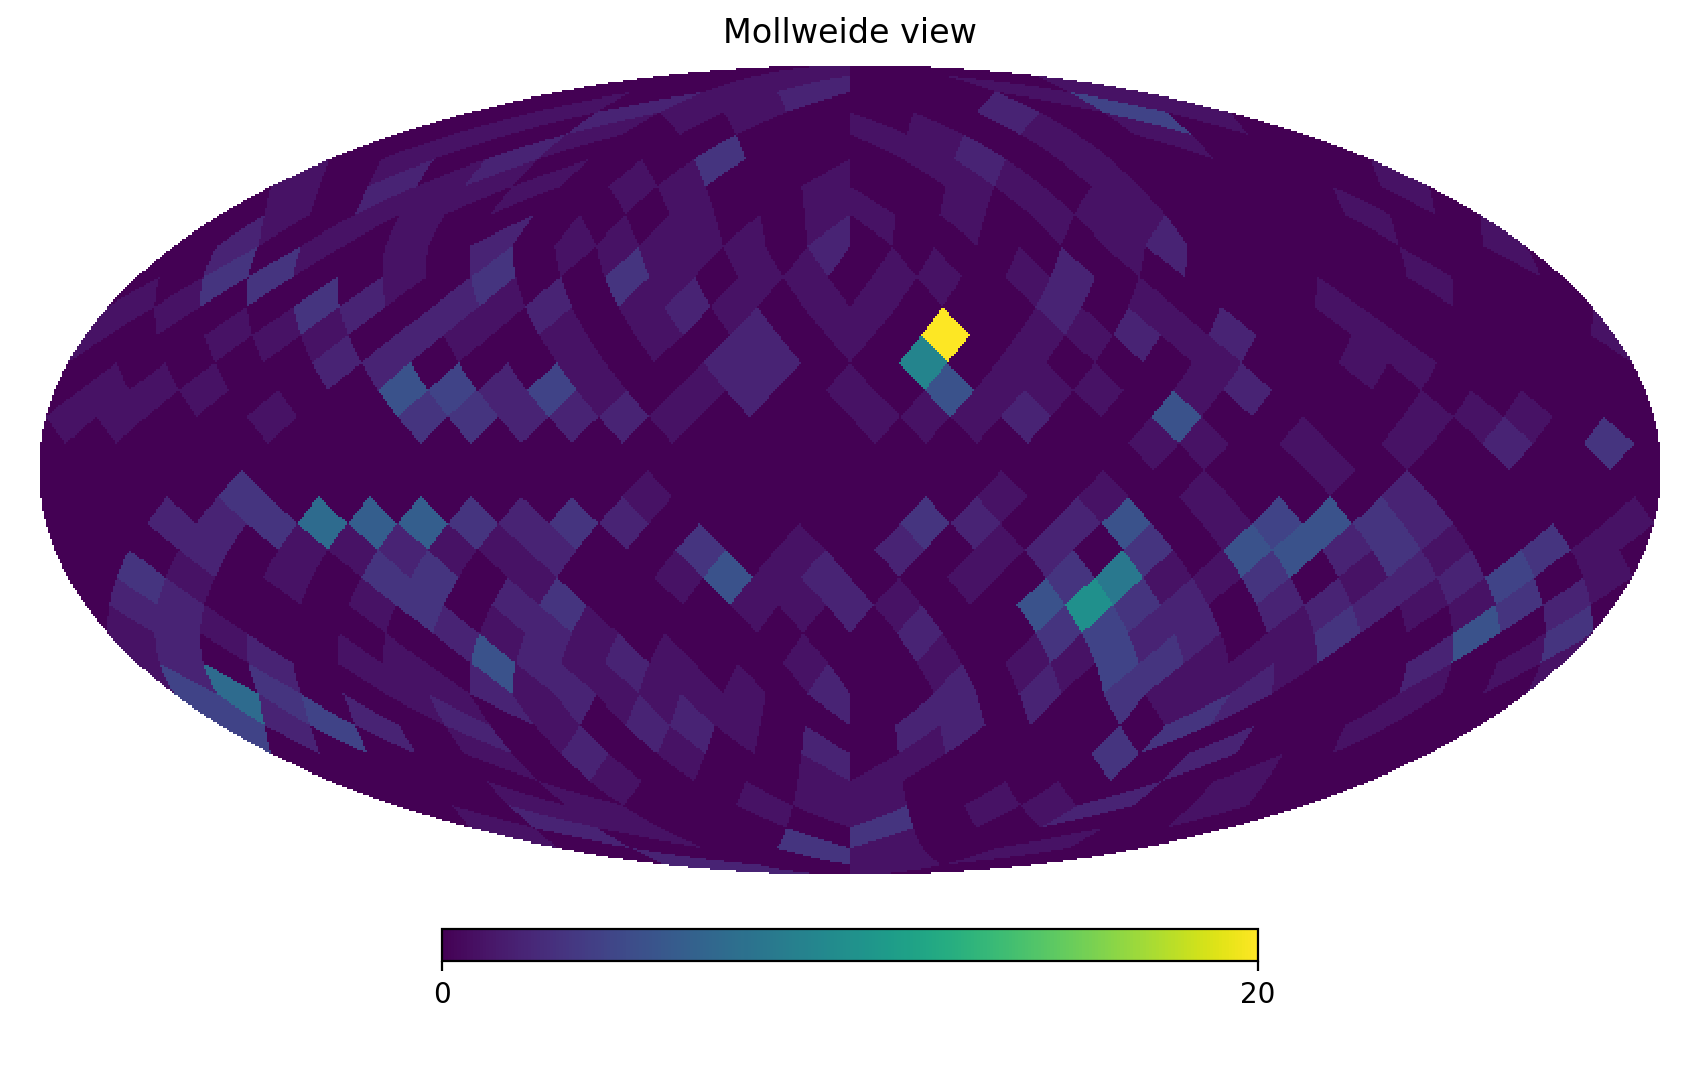

In [272]:
h.mollview(ncmap)
h.mollview(ncmap_rev)

In [251]:
snrthr=4
len(snr[snr>=snrthr]),len(snr_rev[snr_rev>=snrthr])

(5955, 4891)

<IPython.core.display.Javascript object>


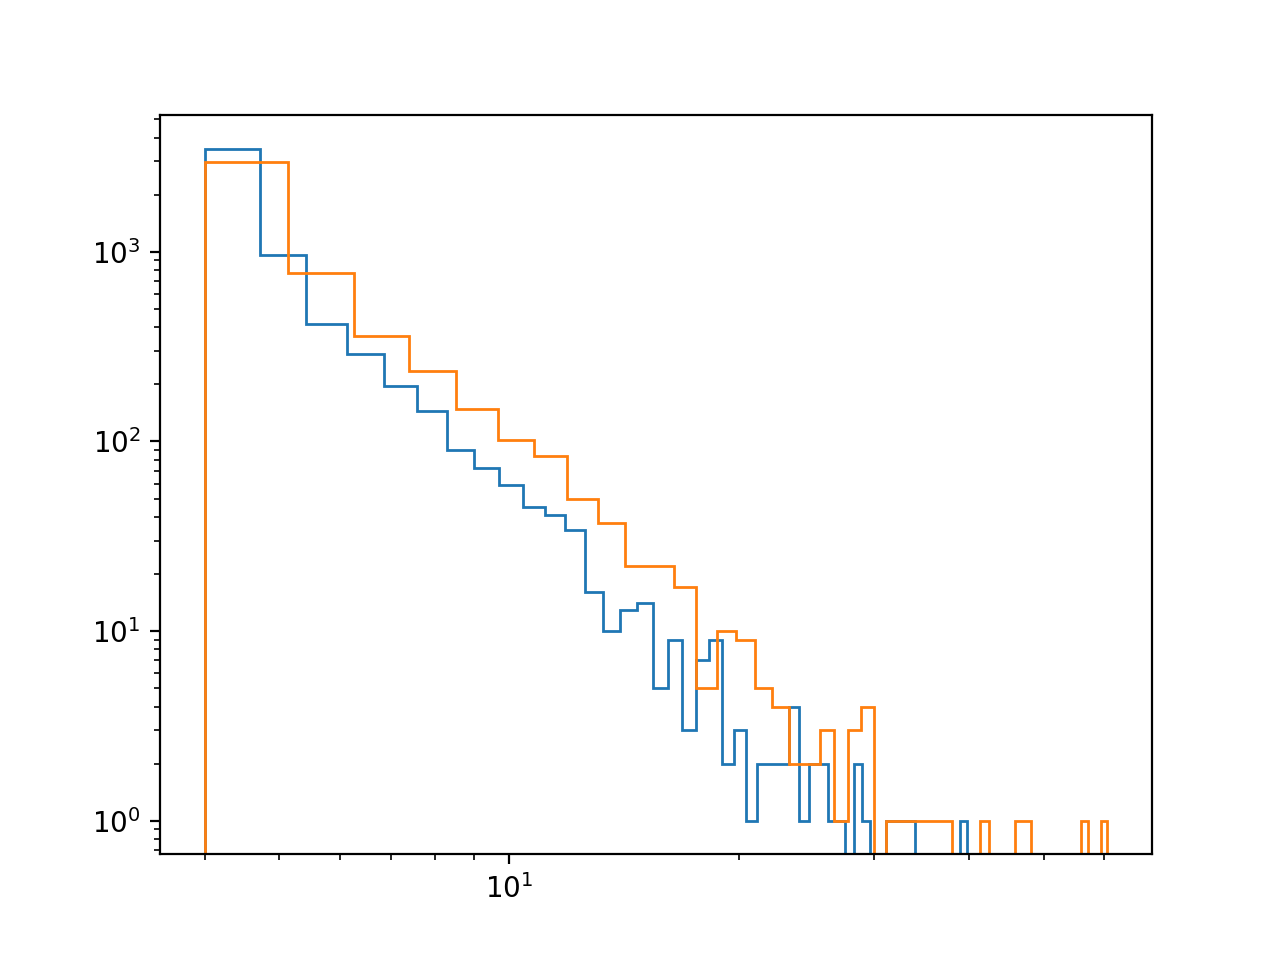

[]

In [252]:
figure()
hist(snr[snr>=snrthr],bins=50,histtype="step")
hist(snr_rev[snr_rev>=snrthr],bins=50,histtype="step")
loglog()

In [147]:
mask=h.read_map(gset.mmfset.gal_mask_name,1)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


IndexError: list index out of range

<IPython.core.display.Javascript object>


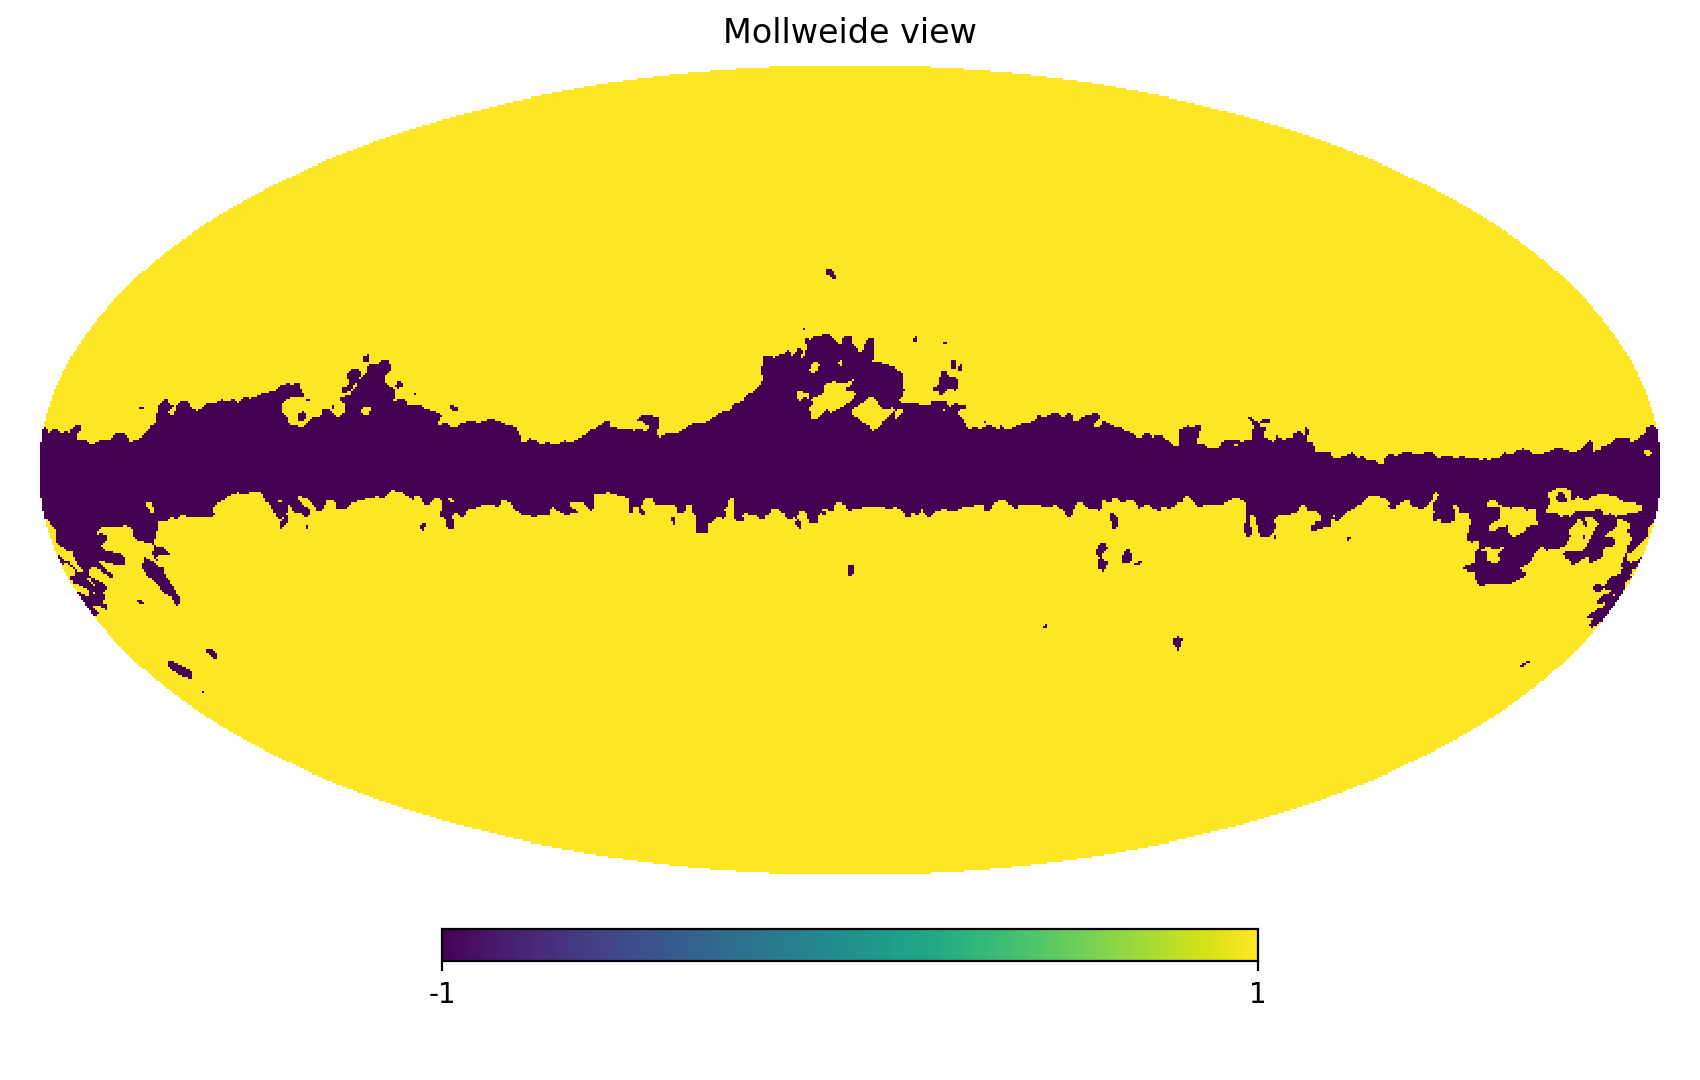

In [148]:
h.mollview(1-mask)

In [149]:
sum(1-mask)/size(mask)

0.6999999682108561

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


<IPython.core.display.Javascript object>


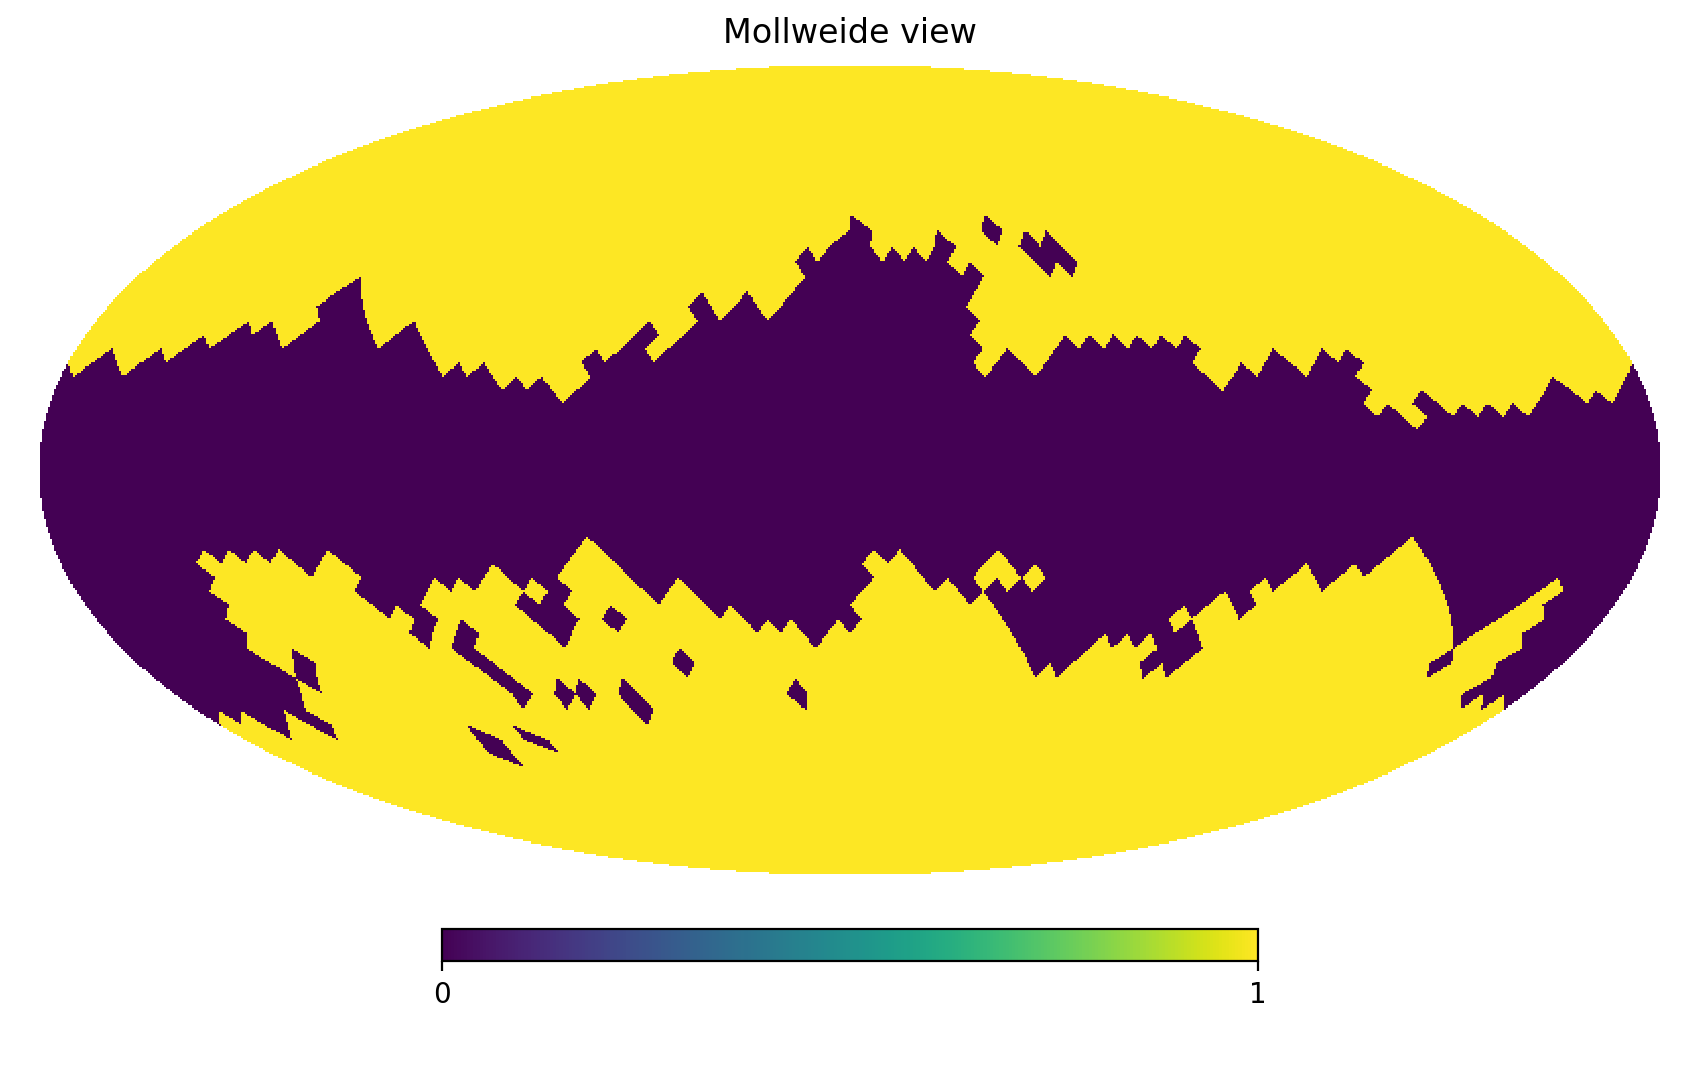

In [124]:
h.ang2pix(8,*cat_summary["Catalogue"][idx]["mp_gal_coord"],lonlat=True)

76

In [127]:
vec=h.ang2vec(*cat_summary["Catalogue"][idx]["mp_gal_coord"],lonlat=True)
h.vec2pix(8,*vec)

76

# Number of clusters detected per tile

In [348]:
from modules.data_preprocess import preprocess_planck_data as ppd
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=0.,cosmo_flag=False)

<IPython.core.display.Javascript object>


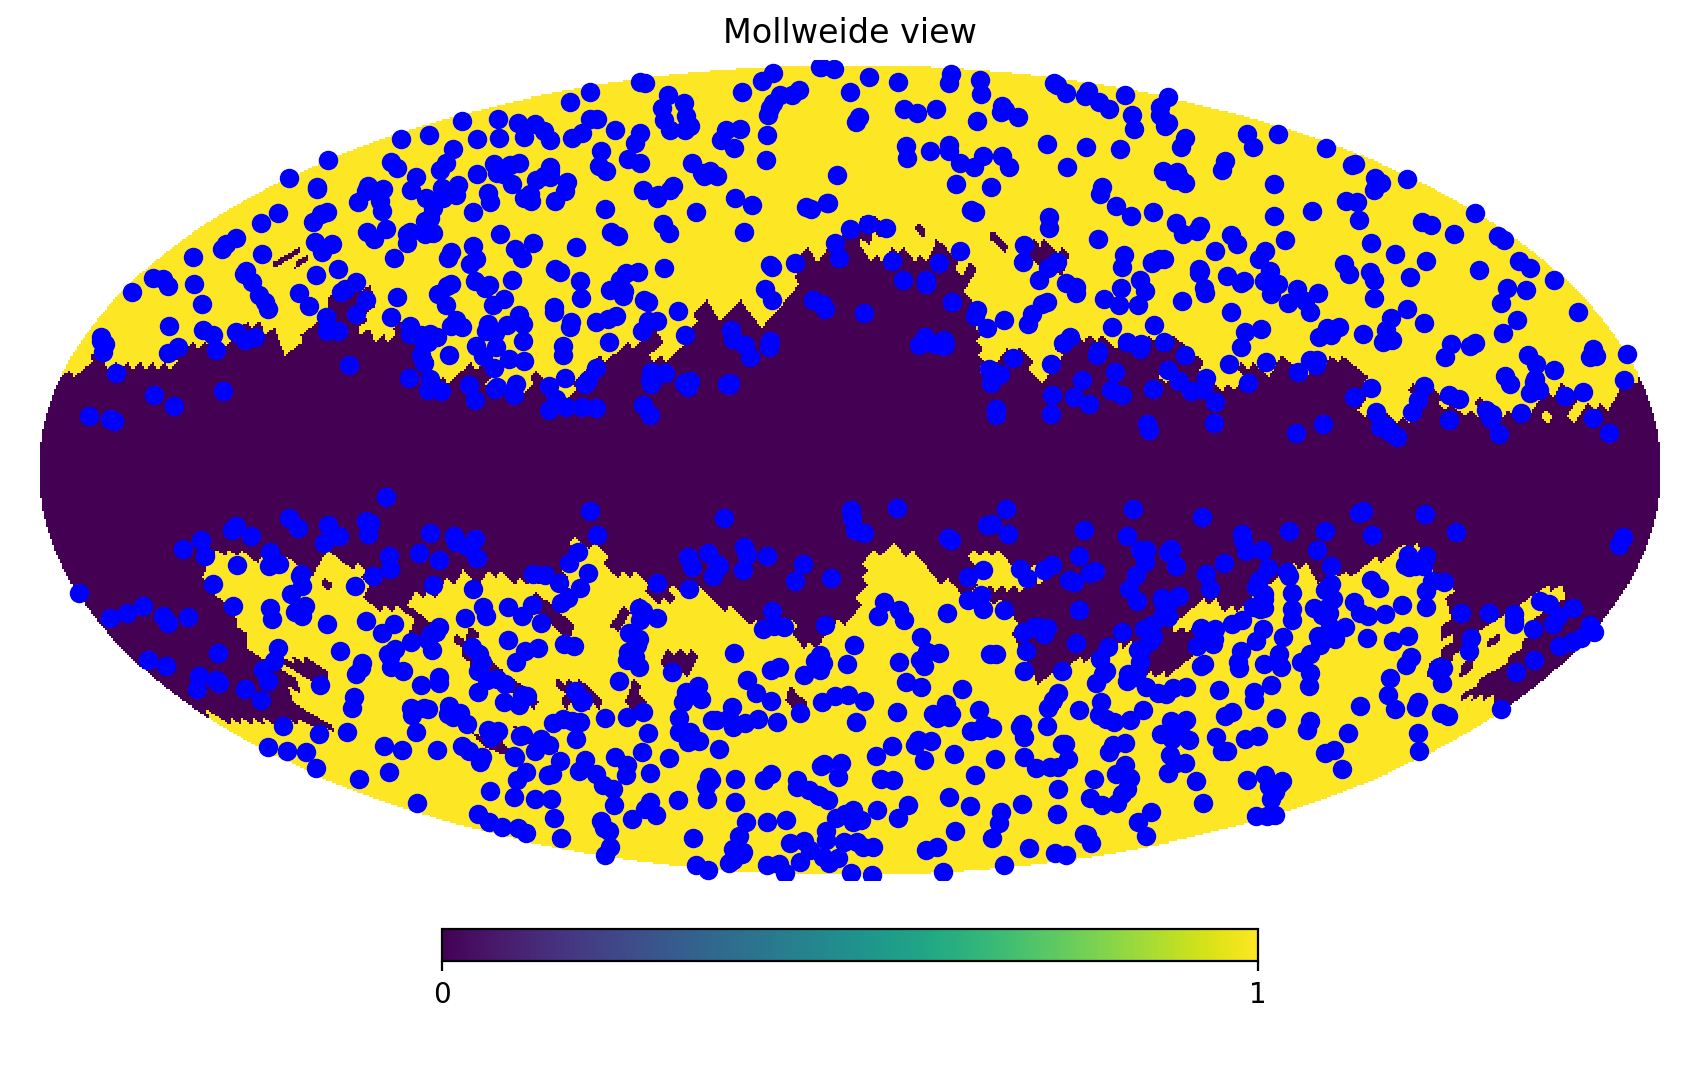

In [360]:
h.mollview(mask)
for idx in range(len(mmf3["INDEX"])):
    glon=mmf3["GLON"][idx]
    glat=mmf3["GLAT"][idx]
#     px=h.ang2pix(nside,glon,glat,lonlat=True)
    h.projscatter(glon,glat,lonlat=True,color="b")

In [362]:
from astropy.io import fits
mmf3=fits.open(gset.mmfset.mmf3_cat_file)

In [364]:
mmf3[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   76 / length of dimension 1                          
NAXIS2  =                 1271 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
EXTNAME = 'PSZ2_INDIVIDUAL'                                                     
PIPELINE= 'MMF3    '                                                            
TTYPE1  = 'INDEX   '                                                            
TFORM1  = 'I       '                                                            
TUNIT1  = 'None    '        